# Team members:

Roudranil Das, MDS202227  
Sheryan Chakraborty, MDS202237

# Importing neccessary libraries

In [19]:
# %pip install category-encoders
# %pip install tabulate
# %pip install optuna
# %pip install skimpy

In [61]:
import os
import time
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna # Bayesian hyperparamter optimisation

from skimpy import clean_columns

from sklearn import metrics, model_selection, preprocessing, tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import category_encoders as ce # More efficient and powerful alternative to sklearn's categorical encoding routines

In [21]:
cmap = ["#c0affb", "#e6a176", "#5eccab", "#cdcdcd",  "#00678a", "#984464", "#c7a2a6"]
sns.set_palette(sns.color_palette(cmap))

plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['font.size'] = 18
plt.rcParams['font.family']
sns.set_style('darkgrid')

warnings.filterwarnings("ignore")

# Task 1

In [22]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred=y_pred))

In [23]:
dataset = pd.read_csv('../data/bollywood-movies.csv')
dataset.head()

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000


In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Movie Name          1698 non-null   object
 1   Release Period      1698 non-null   object
 2   Whether Remake      1698 non-null   object
 3   Whether Franchise   1698 non-null   object
 4   Genre               1698 non-null   object
 5   New Actor           1698 non-null   object
 6   New Director        1698 non-null   object
 7   New Music Director  1698 non-null   object
 8   Lead Star           1698 non-null   object
 9   Director            1698 non-null   object
 10  Music Director      1698 non-null   object
 11  Number of Screens   1698 non-null   int64 
 12  Revenue(INR)        1698 non-null   int64 
 13  Budget(INR)         1698 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 185.8+ KB


## Preprocessing done

$\textcolor{#AED6F1}{\underline{\textbf{Names}}}$

The following columns contains only names:
> _`Movie Name`_, _`Lead Star`_, _`Director`_, _`Music Director`_.  

Although it is reasonable to expect that movie names, and especially directors, lead stars and music directors often dictate the success of a film, from a machine learning perspective, these columns contain nothing but categorical data with too many unique values, which will make encoding impossible:
- one hot encoding with create a highly sparse matrix with roughly 4000 columns
- ordinal encoding is not advised as there should not be any inherent ordering in names.  

We discuss further about this in the report. For the aforementioned reasons we decide to drop these columns.

$\textcolor{#A3E4D7}{\underline{\textbf{Other categorical data}}}$  

The following categorical columns had only 2 categories so we encoded them as 1 and 0:  
> _`whether remake`_, _`whether franchise`_, _`new actor`_, _`new director`_, _`new music director`_.


$\textcolor{#F9E79F}{\underline{\textbf{Feature generation}}}$  

We generated a new feature _`budget/screen`_ = budget amount per number of screens.

The resultant categorical column is then one-hot-encoded.

The other remaining categorical column is target encoded, taking target as the difference of revenue and budget.

In [25]:
dataset[['Revenue(INR)', 'Budget(INR)']] = dataset[['Budget(INR)', 'Revenue(INR)']]
dataset = clean_columns(dataset)
columns_to_be_removed = [
    'movie_name',
    'lead_star',
    'director',
    'music_director'
]
dataset.drop(columns=columns_to_be_removed, inplace=True)

14 column names have been cleaned

In [46]:
def preprocess(X_train, X_test, y_train, y_test):
    columns_to_binary_encode = [
        "whether_remake",
        "whether_franchise",
        "new_actor",
        "new_director",
        "new_music_director",
        "release_period"
    ]
    binary_encoder =  preprocessing.OrdinalEncoder()
    X_train[columns_to_binary_encode] = binary_encoder.fit_transform(X_train[columns_to_binary_encode])
    X_test[columns_to_binary_encode] = binary_encoder.transform(X_test[columns_to_binary_encode])

    target_encoder = ce.TargetEncoder()
    X_train['genre_target'] = target_encoder.fit_transform(X_train['genre'], (y_train - X_train['budget_inr']))
    X_test['genre_target'] = target_encoder.transform(X_test['genre'])

    X_train['budget/screens'] = X_train['budget_inr'] / X_train['number_of_screens'] 
    X_test['budget/screens'] = X_test['budget_inr'] / X_test['number_of_screens'] 

    categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
    ohe = ce.OneHotEncoder(cols=categorical_columns, return_df=True)
    X_train = ohe.fit_transform(X_train)
    X_test = ohe.transform(X_test)
    
    scaler_y = preprocessing.MinMaxScaler()
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

    return X_train, X_test, y_train, y_test

In [47]:
# evaulate the model with k-fold cross validation
def evaluate_model(model, data, target = None, params = None, n_splits = 3):
    reg = model(**params) if params else model()
    kf = model_selection.KFold(n_splits = n_splits, shuffle=True, random_state=0)
    if target:
        X, y = data.drop(columns=[target]), data[target]
    else:
        X, y = data.iloc[:, :-1], data.iloc[:, -1]

    evaulation = {
        'rmse': (root_mean_squared_error, []),
        'r_squared': (metrics.r2_score, [])
    }
    times = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx]
        y_test = y.loc[test_idx]
        X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

        start_time = time.time()
        reg.fit(X_train, y_train)
        end_time = time.time()
        total_time = end_time - start_time
        times.append(total_time)
        y_pred = reg.predict(X_test)
        
        for measure in evaulation.keys():
            m, scores = evaulation[measure]
            scores.append(m(y_true=y_test, y_pred=y_pred))

    print(str(model())[:-2], "\n")
    if params:
        print("Parameters are:")
        print("".join([f"{param}: {param_val}\n" for param, param_val in params.items()]))
    print(pd.DataFrame(
        {
            m: scores for m, (_, scores) in evaulation.items()
        },
        index=[f"Fold {i}" for i in range(1, n_splits+1)]
    ), "\n")

    for measure in evaulation.keys():
        _, scores = evaulation[measure]
        print(f"{measure}: {np.mean(scores):.4f} +- {np.std(scores):.4f}\t Max: {np.max(scores):.4f}")
    print(f"\nTotal  average time taken for the model to fit is {np.mean(times)}")    

In [48]:
evaluate_model(tree.DecisionTreeRegressor, data=dataset, target='revenue_inr')

DecisionTreeRegressor 

            rmse  r_squared
Fold 1  0.058095   0.559771
Fold 2  0.059530   0.302129
Fold 3  0.065940   0.302682 

rmse: 0.0612 +- 0.0034	 Max: 0.0659
r_squared: 0.3882 +- 0.1213	 Max: 0.5598

Total  average time taken for the model to fit is 0.0047455628712972


In [ ]:
def tune_hyperparam_dtree(trial):
    kf = model_selection.KFold(n_splits = 3, shuffle=True, random_state=0)
    target='revenue_inr'
    X, y = dataset.drop(columns=[target]), dataset[target]

    max_depth = trial.suggest_int("max_depth", 2, 16)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    reg = tree.DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    scores = []

    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx]
        y_test = y.loc[test_idx]
        X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        scores.append(-metrics.r2_score(y_true=y_test, y_pred=y_pred))

    return np.mean(scores)

study = optuna.create_study()
start_time = time.time()
study.optimize(tune_hyperparam_dtree, n_trials = 50)
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken for hyper-parameter tuning is {total_time}")


In [59]:
best_params = study.best_params
evaluate_model(tree.DecisionTreeRegressor, data=dataset, target='revenue_inr', params=best_params)

DecisionTreeRegressor 

Parameters are:
max_depth: 4
min_samples_split: 9
min_samples_leaf: 3

            rmse  r_squared
Fold 1  0.045118   0.734468
Fold 2  0.035515   0.751608
Fold 3  0.041993   0.717195 

rmse: 0.0409 +- 0.0040	 Max: 0.0451
r_squared: 0.7344 +- 0.0140	 Max: 0.7516

Total  average time taken for the model to fit is 0.002796729405721029


In [51]:
target = 'revenue_inr'
X, y = dataset.drop(columns=[target]), dataset[target]
reg = tree.DecisionTreeRegressor(**best_params)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

%load_ext memory_profiler
%memit reg.fit(X_train, y_train)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 220.71 MiB, increment: 0.00 MiB


In [60]:
best_params

{'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}

# Task 2


## BANK DATASET

In [33]:
DATA_DIR = os.path.join("..", "data")
df = pd.read_csv(
    os.path.join(DATA_DIR, "bank-additional-full.csv"), 
    sep=";",
)

# EDA

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [35]:
categorical_columns = [c for c in df if df[c].dtype == 'object']
numeric_columns = [c for c in df.columns if c not in categorical_columns]

## Preprocessing done

$\textcolor{#AED6F1}{\underline{\textbf{Client data}}}$
1. Columns to be one-hot encoded:
    - _`job`_  - Target encoding
    - _`marital`_ - Target encoding
    - _`education`_ - Target encoding
    - _`month`_ - One-Hot encoding
2. Drop _`contact`_, _`day_of_week`_ - No effect on the target variable
3. Drop _`previous`_ - Almost nobody was contacted previously 
4. Keep _`duration`_ - The model is for benchmark puproses
5. _`housing`_ and _`loan`_ - One-Hot encoding
6. Drop _`default`_ - Significant amount of unknowns

$\textcolor{#A3E4D7}{\underline{\textbf{Other data}}}$  

7. Drop _`pdays`_ - Significant amount of 999 in the colums
8. _`poutcome`_ - Ordinal encoding

$\textcolor{#F9E79F}{\underline{\textbf{Social attributes}}}$  

9. Drop - _`emp.var.rate`_ and _`nr.employed`_ - _`euribor3m`_ is highly correlated to _`emp.var.rate`_ and _`nr.employed`_

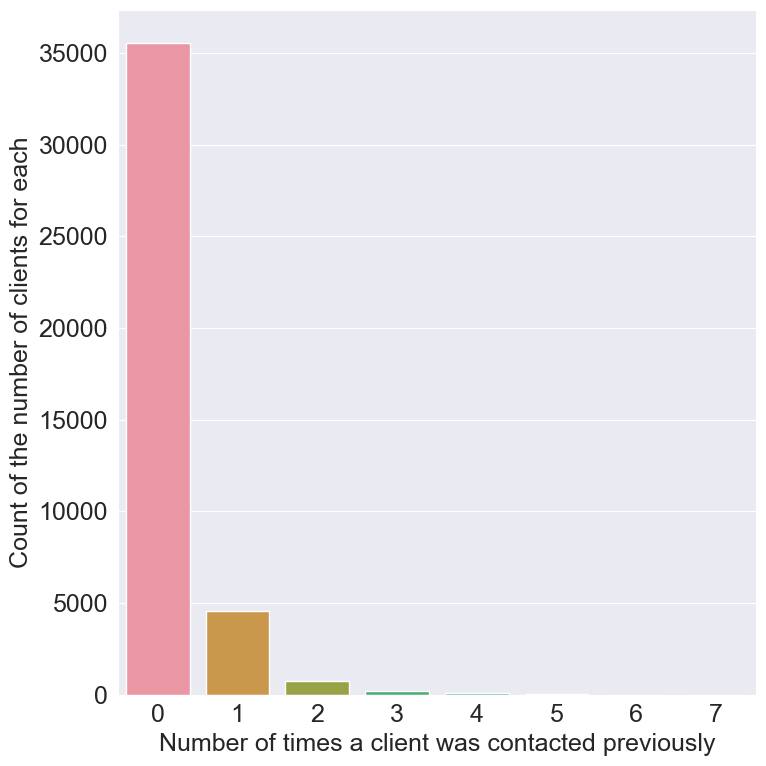

In [36]:
# how many times a person was contacted in a previous campaign
# we can see that almost 35k out of approx 41k people are new customers
sns.countplot(data=df, x = "previous")
plt.xlabel("Number of times a client was contacted previously")
plt.ylabel("Count of the number of clients for each")
plt.tight_layout();

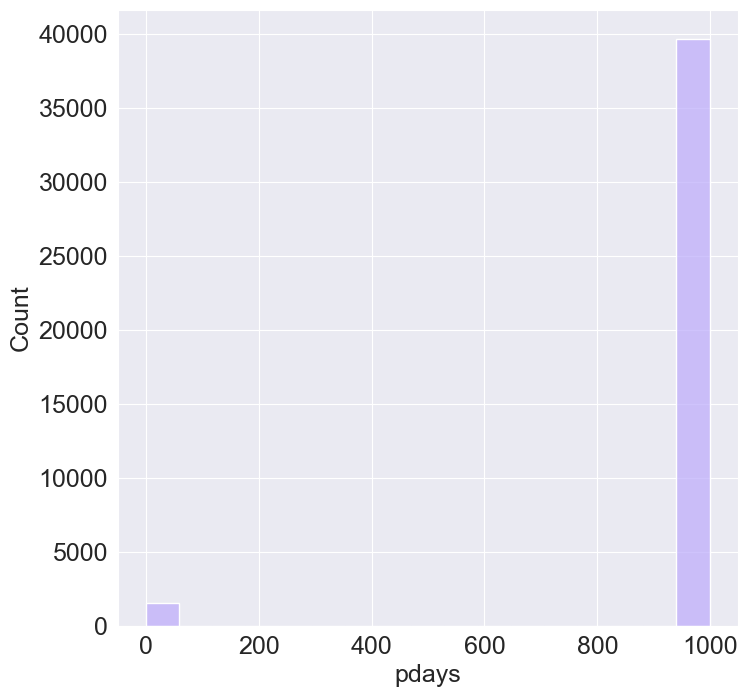

In [37]:
# Hitogram to show how many values in pdays are 999
sns.histplot(data=df, x="pdays");

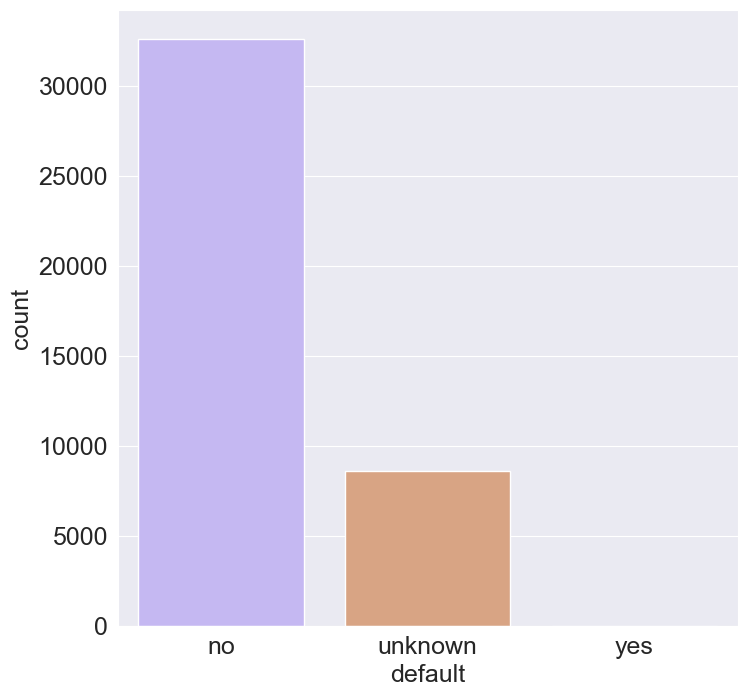

In [38]:
# significant amount of unknowns in default
sns.countplot(data=df, x="default");

In [39]:
# how mamy unknowns are there in all the categorical columns?
categorical_columns = [c for c in df if df[c].dtype == 'object']
numeric_columns = [c for c in df.columns if c not in categorical_columns]

def show_perc_unknown(df):
    perc = {}
    for c in categorical_columns:
        try:
            perc[c] = [
                df[c].value_counts(normalize=True)['unknown'] * 100,
                int(df[c].value_counts()['unknown']),
            ]
        except:
            perc[c] = [0, 0]

    return pd.DataFrame.from_dict(perc, orient="index", columns=["Percentage of unknown", "count of unknown"]).sort_values(by="Percentage of unknown", ascending=False)
show_perc_unknown(df)

,Percentage of unknown,count of unknown
default,20.872584,8597
education,4.202680,1731
housing,2.403613,990
loan,2.403613,990
job,0.801204,330
marital,0.194231,80
contact,0.000000,0
month,0.000000,0
day_of_week,0.000000,0
poutcome,0.000000,0


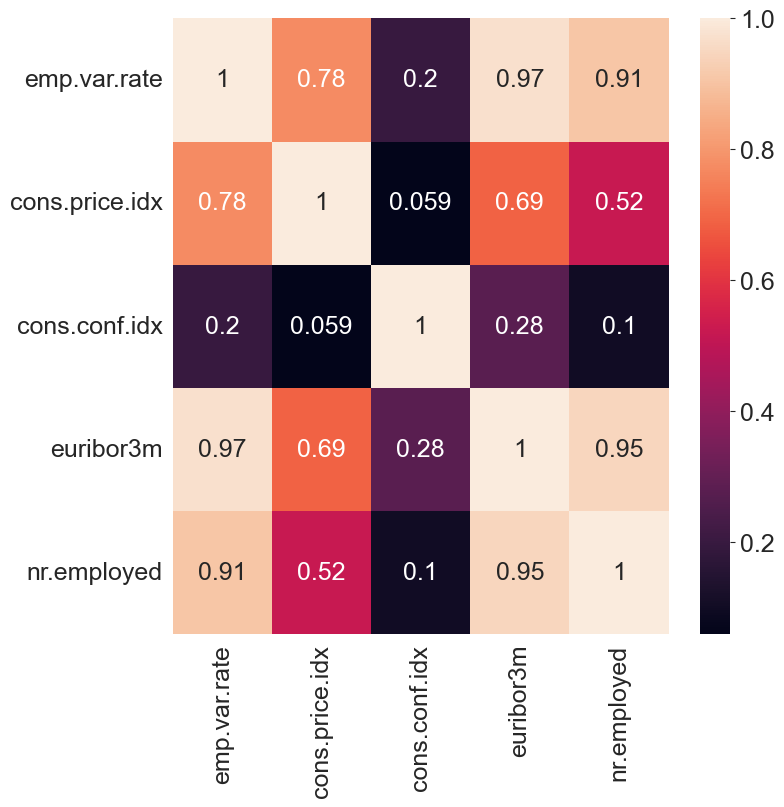

In [40]:
# correlation plot of the last 5 consumer index variables
sns.heatmap(
    df[[
        "emp.var.rate", 
        "cons.price.idx", 
        "cons.conf.idx", 
        "euribor3m",
        "nr.employed"
    ]].corr(),
    annot=True);

In [63]:
# label encoding the target
df["y"] = LabelEncoder().fit_transform(df["y"])

# correlated numerical columns
correlated_columns_to_be_dropped = ["emp.var.rate", "nr.employed"]    

# the next two functions are helper functions to simplify the preprocessing pipeline
def preprocess_both(X):
    X.drop(columns=correlated_columns_to_be_dropped, inplace=True)
    X.drop(columns=["pdays", "day_of_week", "contact", "default", "previous"], inplace=True)
    # one hot encoding
    X = pd.concat(
    [
        X.drop(columns=["housing", "loan", "month"]),
        pd.get_dummies(X[[
            "housing", "loan", "month"
        ]])
    ],
    axis=1,
    )
    # encoding poutcome
    X["poutcome"] = X["poutcome"].map({
    "failure": 1,
    "nonexistent": 2,
    "success": 3
    })

    return X

def preprocess(X_train, y_train, X_test=None):
    X_train = preprocess_both(X_train)
    X_test = preprocess_both(X_test)
    # identifier columns to indicate the presence of unknown in these columns
    for c in ["job", "marital", "education"]:
        X_train[f"{c}_is_unknown"] = X_train[c].apply(lambda x: 1 if x=="unknown" else 0)
        X_test[f"{c}_is_unknown"] = X_test[c].apply(lambda x: 1 if x == "unknown" else 0)
    # target encoding
    encoder = ce.TargetEncoder(
        ["job", "marital", "education"],
        return_df=True)
    encoder.fit(X_train, y_train)
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)

    return X_train, X_test
    


## Models

In [64]:
# evaulate the model with k-fold cross validation
def evaluate_model(model, data, params = None, n_splits = 5, data_ = 1):
    clf = model(**params) if params else model()
    # trying a 5-fold cv for robust results
    skf = model_selection.StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]

    evaulation = {
        'accuracy': (metrics.accuracy_score, []),
        'recall': (metrics.recall_score, []),
        'precision': (metrics.precision_score, []),
        'f1_score': (metrics.f1_score, [])
    }
    times=[]
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx]
        y_test = y.loc[test_idx]
        if data_ == 1:
            X_train, X_test = preprocess(X_train, y_train, X_test)
        
        if data_ == 2:
            X_train, X_test = preprocess_2_(X_train,X_test)
        
        start_time = time.time()
        clf.fit(X_train, y_train)
        end_time = time.time()
        total_time = end_time - start_time
        times.append(total_time)
        y_pred = clf.predict(X_test)
        
        for measure in evaulation.keys():
            m, scores = evaulation[measure]
            scores.append(m(y_true=y_test, y_pred=y_pred))

    print(str(model())[:-2], "\n")
    if params:
        print("Parameters are:")
        print("".join([f"{param}: {param_val}\n" for param, param_val in params.items()]))
    print(pd.DataFrame(
        {
            m: scores for m, (_, scores) in evaulation.items()
        },
        index=[f"Fold {i}" for i in range(1, n_splits+1)]
    ), "\n")

    for measure in evaulation.keys():
        _, scores = evaulation[measure]
        print(f"{measure}: {np.mean(scores):.4f} +- {np.std(scores):.4f}\t Max: {np.max(scores):.4f}")
    print(f"\nTotal  average time taken for the model to fit is {np.mean(times)}")    

### Random Forest

In [65]:
evaluate_model(RandomForestClassifier, data=df,data_=1)

RandomForestClassifier 

        accuracy    recall  precision  f1_score
Fold 1  0.914542  0.512931   0.653846  0.574879
Fold 2  0.911265  0.484914   0.640114  0.551809
Fold 3  0.908594  0.496767   0.617135  0.550448
Fold 4  0.911376  0.507543   0.633065  0.563397
Fold 5  0.915503  0.501078   0.666189  0.571956 

accuracy: 0.9123 +- 0.0025	 Max: 0.9155
recall: 0.5006 +- 0.0096	 Max: 0.5129
precision: 0.6421 +- 0.0169	 Max: 0.6662
f1_score: 0.5625 +- 0.0100	 Max: 0.5749

Total  average time taken for the model to fit is 2.035098934173584


#### Hyperparameter optimisation

#### Grid search cross validation on hyperparameters

In [67]:
params = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}
skf = StratifiedKFold(shuffle=True, random_state=0)
x = df.iloc[:, :-1]
X_test = df.iloc[:, [-1]]
d_copy,X_test,Y_train,Y_test=train_test_split(x,X_test,test_size=0.2,random_state=42)
d_copy,X_test=preprocess(d_copy,Y_train,X_test)
clf = RandomForestClassifier()
gcv = model_selection.GridSearchCV(estimator=clf,param_grid=params,cv=skf)
start_time=time.time()
gcv.fit(d_copy,Y_train)
end_time=time.time()
total_time=end_time - start_time
print(total_time)

350.90464091300964


In [68]:
gcv.best_params_

{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [69]:
clf = RandomForestClassifier(**gcv.best_params_)

%reload_ext memory_profiler
%memit clf.fit(d_copy, Y_train)

peak memory: 290.41 MiB, increment: 3.88 MiB


Train score 0.9508649468892261
Test score 0.9122359796067007
Train Confusion matrix


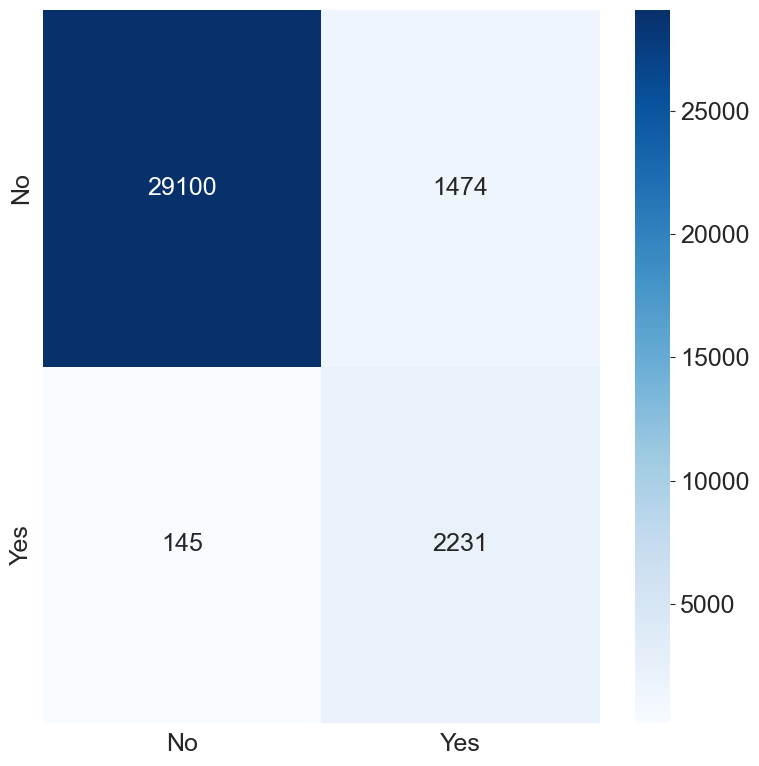

Test Confusion matrix


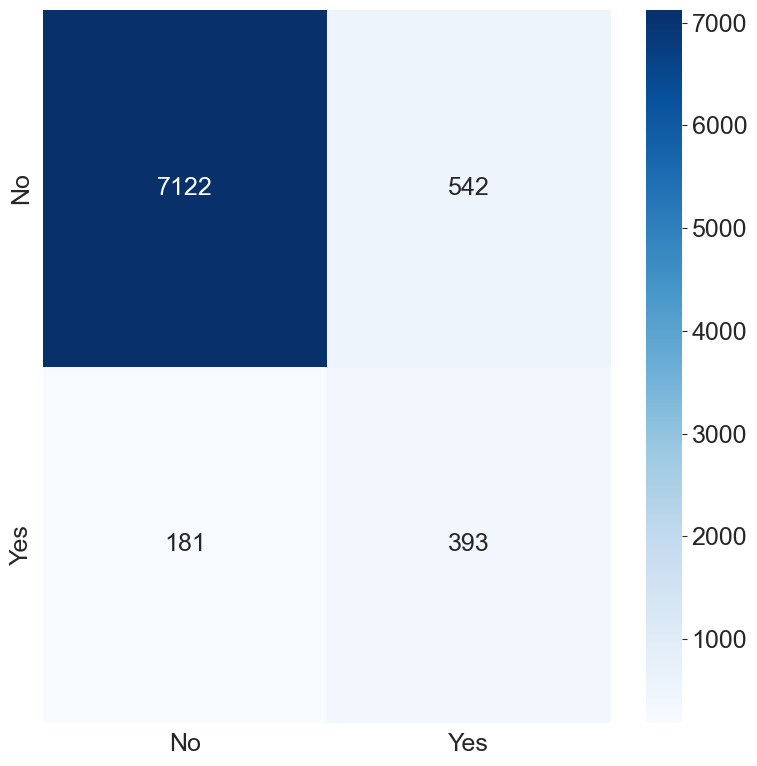

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7303
           1       0.68      0.42      0.52       935

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238

Total time taken for the GridSearchCv is 350.90464091300964


In [70]:
cv_model = gcv.best_estimator_
cv_model.fit(d_copy,Y_train)
Y1_train_pred = cv_model.predict(d_copy)
Y1_test_pred = cv_model.predict(X_test)

classes = ["No", "Yes"]

def plot_confusionmatrix(Y1_train_pred,Y1_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(Y1_train_pred,Y1_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()




print(f'Train score {accuracy_score(Y1_train_pred,Y_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y_test)}')
plot_confusionmatrix(Y1_train_pred,Y_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y_test,dom='Test')
print(metrics.classification_report(Y_test, Y1_test_pred))
print(f"Total time taken for the GridSearchCv is {total_time}")

## Boosting by Decision Stumps / AdaBoosting

In [71]:
X_train = df.iloc[:, :-1]
Y_train = df.iloc[:, [-1]]
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=45)
X_train,X_test = preprocess(X_train,Y_train,X_test)
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 45, max_depth = 1,),random_state = 45, n_estimators = 100, learning_rate = 0.8)
start_time = time.time()
clf.fit(X_train,Y_train)
end_time = time.time()
total_time = end_time - start_time
print(total_time)

1.9031150341033936


In [72]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 45, max_depth = 1,),random_state = 45, n_estimators = 100, learning_rate = 0.8)

%reload_ext memory_profiler
%memit clf.fit(X_train, Y_train)

peak memory: 292.28 MiB, increment: 3.75 MiB


Train score 0.9116236722306525
Test score 0.9095654285020636
Train Confusion matrix


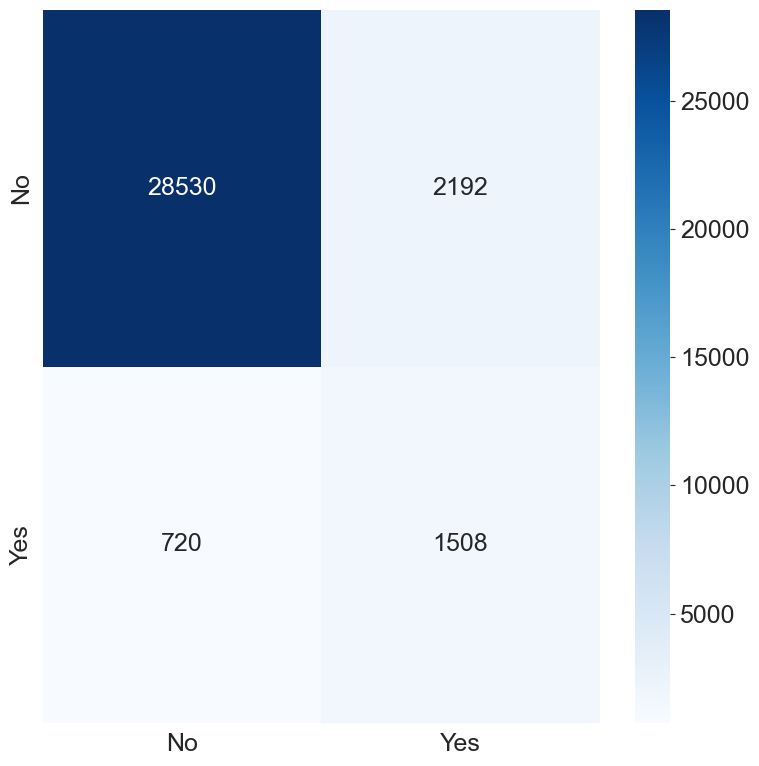

Test Confusion matrix


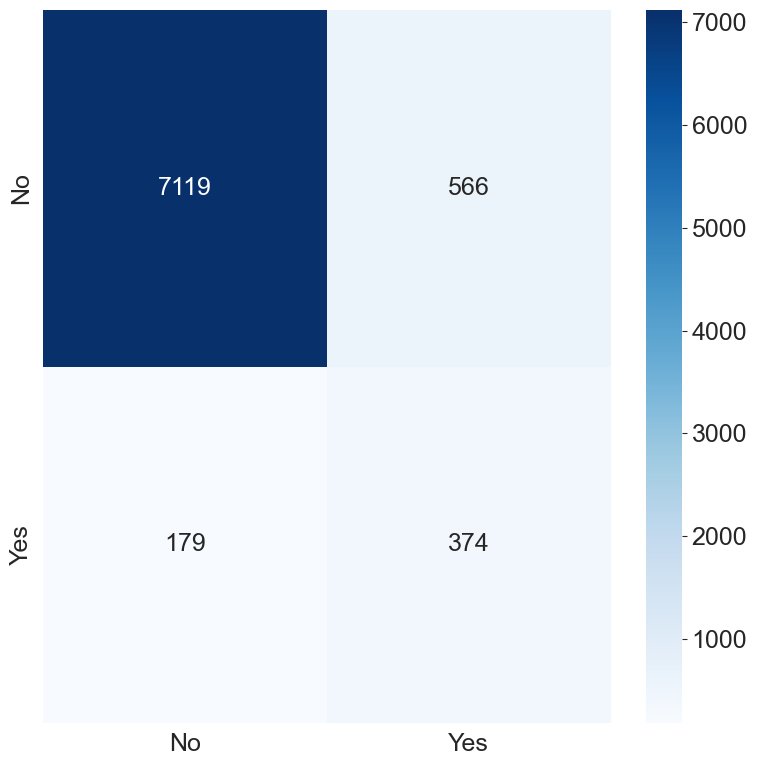

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7298
           1       0.68      0.40      0.50       940

    accuracy                           0.91      8238
   macro avg       0.80      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238

Total time taken for AdaBoosting is 1.9031150341033936


In [73]:
Y1_train_pred = clf.predict(X_train)
Y1_test_pred = clf.predict(X_test)

classes = ["No", "Yes"]

def plot_confusionmatrix(Y1_train_pred,Y1_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(Y1_train_pred,Y1_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()




print(f'Train score {accuracy_score(Y1_train_pred,Y_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y_test)}')
plot_confusionmatrix(Y1_train_pred,Y_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y_test,dom='Test')
print(metrics.classification_report(Y_test, Y1_test_pred))
print(f"Total time taken for AdaBoosting is {total_time}")

## BOLLYWOOD MOVIES DATASET

In [74]:
dataset=pd.read_csv("../data/bollywood-movies.csv")

# EDA

In [75]:
dataset.head(5)

,Movie Name,Release Period,Whether Remake,Whether Franchise,Genre,New Actor,New Director,New Music Director,Lead Star,Director,Music Director,Number of Screens,Revenue(INR),Budget(INR)
0,Golden Boys,Normal,No,No,suspense,Yes,No,No,Jeet Goswami,Ravi Varma,Baba Jagirdar,5,5000000,85000
1,Kaccha Limboo,Holiday,No,No,drama,Yes,No,Yes,Karan Bhanushali,Sagar Ballary,Amardeep Nijjer,75,15000000,825000
2,Not A Love Story,Holiday,No,No,thriller,No,No,No,Mahie Gill,Ram Gopal Verma,Sandeep Chowta,525,75000000,56700000
3,Qaidi Band,Holiday,No,No,drama,Yes,No,No,Aadar Jain,Habib Faisal,Amit Trivedi,800,210000000,4500000
4,Chaatwali,Holiday,No,No,adult,Yes,Yes,Yes,Aadil Khan,Aadil Khan,Babloo Ustad,1,1000000,1075000


In [76]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698 entries, 0 to 1697
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Movie Name          1698 non-null   object
 1   Release Period      1698 non-null   object
 2   Whether Remake      1698 non-null   object
 3   Whether Franchise   1698 non-null   object
 4   Genre               1698 non-null   object
 5   New Actor           1698 non-null   object
 6   New Director        1698 non-null   object
 7   New Music Director  1698 non-null   object
 8   Lead Star           1698 non-null   object
 9   Director            1698 non-null   object
 10  Music Director      1698 non-null   object
 11  Number of Screens   1698 non-null   int64 
 12  Revenue(INR)        1698 non-null   int64 
 13  Budget(INR)         1698 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 185.8+ KB


## Preprocessing done

$\textcolor{#AED6F1}{\underline{\textbf{Names}}}$

The following columns contains only names:
> _`Movie Name`_, _`Lead Star`_, _`Director`_, _`Music Director`_.  

Although it is reasonable to expect that movie names, and especially directors, lead stars and music directors often dictate the success of a film, from a machine learning perspective, these columns contain nothing but categorical data with too many unique values, which will make encoding impossible:
- one hot encoding with create a highly sparse matrix with roughly 4000 columns
- ordinal encoding is not advised as there should not be any inherent ordering in names.  

We discuss further about this in the report. For the aforementioned reasons we decide to drop these columns.

$\textcolor{#A3E4D7}{\underline{\textbf{Other categorical data}}}$  

The following categorical columns had only 2 categories so we encoded them as 1 and 0:  
> _`whether remake`_, _`whether franchise`_, _`new actor`_, _`new director`_, _`new music director`_.


$\textcolor{#F9E79F}{\underline{\textbf{Number of screens}}}$  

The distribution of the number of screens is hihgly positively skewed. Hence we first min-max scale the data, and then quantile encode it:  
- if $\textit{num\_screens}\leq Q_1$ then encode it as _`low`_
- if $Q_1<\textit{num\_screens}\leq Q_3$ then encode it as _`moderate`_
- if $Q_3<\textit{num\_screens}$ then encode it as _`high`_

The resultant categorical column is then one-hot-encoded.

All other categorical columns are one-hot encoded.

In [77]:
d_copy = dataset.copy()
d_copy.columns = d_copy.columns.str.lower()
d_copy["target"] = np.where((d_copy["revenue(inr)"] < d_copy["budget(inr)"]),1,0)

In [78]:
# unique values in all the columns
for i in d_copy.columns:
    if d_copy[i].dtype == "object":
        print(i)
        print(d_copy[i].unique())
        print("\n")

movie name
['Golden Boys' 'Kaccha Limboo' 'Not A Love Story' ...
 'Dunno Y Na Jaane Kyun' 'Taj Mahal - An Eternal Love Story'
 'Mr. Hot Mr. Kool']


release period
['Normal' 'Holiday']


whether remake
['No' 'Yes']


whether franchise
['No' 'Yes']


genre
['suspense' 'drama' 'thriller' 'adult' 'comedy' 'action' 'love_story'
 'rom__com' 'horror' 'fantasy' 'masala' 'mythological' 'animation'
 'documentary']


new actor
['Yes' 'No']


new director
['No' 'Yes']


new music director
['No' 'Yes']


lead star
['Jeet Goswami' 'Karan Bhanushali' 'Mahie Gill' 'Aadar Jain' 'Aadil Khan'
 'Aakar Kaushik' 'Aakash' 'Aamir Bashir' 'Aamir Khan' 'Aanamika Bawa'
 'Aarun Nagar' 'Aaryan' 'Aasad Mirza' 'Aashish Chanana'
 'Aashish Chaudhary' 'Aasif Albela' 'Aatri Kumar' 'Abhay Bakshi'
 'Abhay Deol' 'Abhijeet Sawant' 'Abhinav Shukla' 'Abhishek Anand'
 'Abhishek Bachchan' 'Abhishek Gupta' 'Abhishek Sharma' 'Abhishek Urade'
 'Adah Sharma' 'Adam Bedi' 'Adhvik Mahajan' 'Adhyayan Suman'
 'Adil Hussain' 'Aditi Inam

Range of the number of screens: 4599


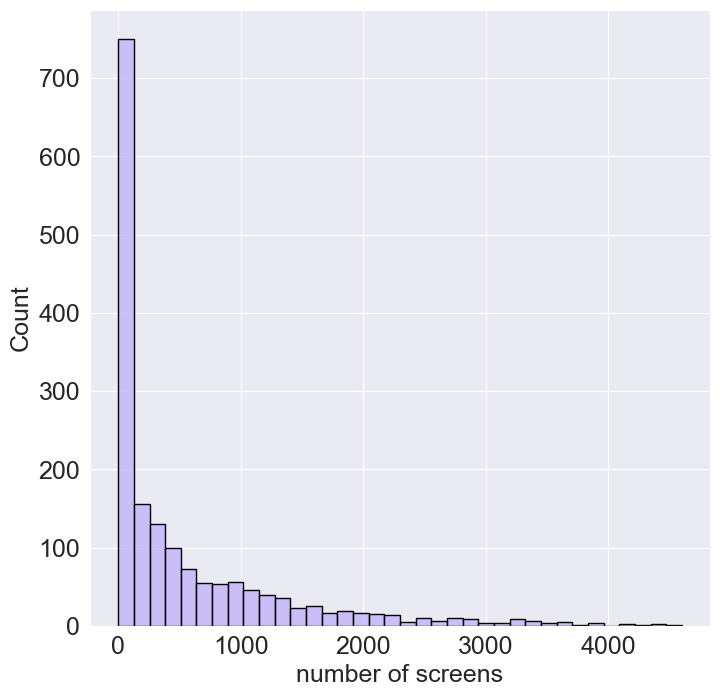

In [79]:
# dealing with the number of screens
print(f"Range of the number of screens: {max(d_copy['number of screens'])-min(d_copy['number of screens'])}")

sns.histplot(d_copy, x="number of screens", edgecolor="black");

In [80]:
def preprocess_2_(X_train,X_test):
    # ordinal encoding of the categorical columns
    X_train["whether remake"]=np.where((X_train["whether remake"]=="Yes"),1,0)
    X_train["whether franchise"]=np.where((X_train["whether franchise"]=="Yes"),1,0)
    X_train["new actor"]=np.where((X_train["new actor"]=="Yes"),1,0)
    X_train["new director"]=np.where((X_train["new director"]=="Yes"),1,0)
    X_train["new music director"]=np.where((X_train["new music director"]=="Yes"),1,0)
    X_train.drop(["revenue(inr)","movie name","lead star","director","music director"],axis=1,inplace=True)

    X_test["whether remake"]=np.where((X_test["whether remake"]=="Yes"),1,0)
    X_test["whether franchise"]=np.where((X_test["whether franchise"]=="Yes"),1,0)
    X_test["new actor"]=np.where((X_test["new actor"]=="Yes"),1,0)
    X_test["new director"]=np.where((X_test["new director"]=="Yes"),1,0)
    X_test["new music director"]=np.where((X_test["new music director"]=="Yes"),1,0)
    X_test.drop(["revenue(inr)","movie name","lead star","director","music director"],axis=1,inplace=True)
    

 # mapping from num_screen -> low/moderate/high
    l1=[] 

    for i in X_train["number of screens"]:
        if i>X_train["number of screens"].quantile(.75):
            l1.append("High")
        elif i>X_train["number of screens"].quantile(.25) and i<X_train["number of screens"].quantile(.75):
            l1.append("Moderate")
        else:
            l1.append("Low")  
    cg=pd.DataFrame(l1)
    X_train["number of screens"] = cg[0]
    
    l2=[]
    for i in X_test["number of screens"]:
        if i>X_test["number of screens"].quantile(.75):
            l2.append("High")
        elif i>X_test["number of screens"].quantile(.25) and i<X_test["number of screens"].quantile(.75):
            l2.append("Moderate")
        else:
            l2.append("Low")

    dg=pd.DataFrame(l2)
    X_test["number of screens"] = dg[0]

    # one hot encoding
    dummy=pd.get_dummies(X_train[["release period","genre","number of screens"]],drop_first=False)
    X_train=pd.concat([X_train,dummy],axis=1).drop(["release period","genre","number of screens"],axis=1)

    # one hot encoding
    dummy=pd.get_dummies(X_test[["release period","genre","number of screens"]],drop_first=False)
    X_test=pd.concat([X_test,dummy],axis=1).drop(["release period","genre","number of screens"],axis=1)          

    # standardising the budget column
    X_train["budget(inr)"] = MinMaxScaler().fit_transform(X_train[["budget(inr)"]])
    # standardising the budget column
    X_test["budget(inr)"] = MinMaxScaler().fit_transform(X_test[["budget(inr)"]])

    return X_train , X_test

In [81]:
# ordinal encoding of the categorical columns

d_copy["whether remake"]=np.where((d_copy["whether remake"]=="Yes"),1,0)
d_copy["whether franchise"]=np.where((d_copy["whether franchise"]=="Yes"),1,0)
d_copy["new actor"]=np.where((d_copy["new actor"]=="Yes"),1,0)
d_copy["new director"]=np.where((d_copy["new director"]=="Yes"),1,0)
d_copy["new music director"]=np.where((d_copy["new music director"]=="Yes"),1,0)
d_copy.drop(["revenue(inr)","movie name","lead star","director","music director"],axis=1,inplace=True)


# mapping from num_screen -> low/moderate/high

l1=[] 

for i in d_copy["number of screens"]:
    if i>d_copy["number of screens"].quantile(.75):
        l1.append("High")
    elif i>d_copy["number of screens"].quantile(.25) and i<d_copy["number of screens"].quantile(.75):
        l1.append("Moderate")
    else:
        l1.append("Low")  
cg=pd.DataFrame(l1)
d_copy["number of screens"] = cg[0]

# one hot encoding
dummy=pd.get_dummies(d_copy[["release period","genre","number of screens"]],drop_first=False)
d_copy=pd.concat([d_copy,dummy],axis=1).drop(["release period","genre","number of screens"],axis=1)

# standardising the budget column
d_copy["budget(inr)"] = MinMaxScaler().fit_transform(d_copy[["budget(inr)"]])

target =  d_copy["target"]
d_copy.drop(["target"],axis=1,inplace= True)

In [82]:
d_copy

,whether remake,whether franchise,new actor,new director,new music director,budget(inr),release period_Holiday,release period_Normal,genre_action,genre_adult,genre_animation,genre_comedy,genre_documentary,genre_drama,genre_fantasy,genre_horror,genre_love_story,genre_masala,genre_mythological,genre_rom__com,genre_suspense,genre_thriller,number of screens_High,number of screens_Low,number of screens_Moderate
0,0,0,1,0,0,0.000010,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,1,0,1,0.000102,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0.007072,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0.000560,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,1,1,0.000133,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0,0,0,1,0,0.011085,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1694,0,0,0,1,1,0.000008,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1695,0,0,0,0,0,0.000105,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1696,0,0,0,1,0,0.003874,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [83]:
target=pd.DataFrame(target)
target

,target
0,0
1,0
2,0
3,0
4,1
...,...
1693,1
1694,0
1695,0
1696,0


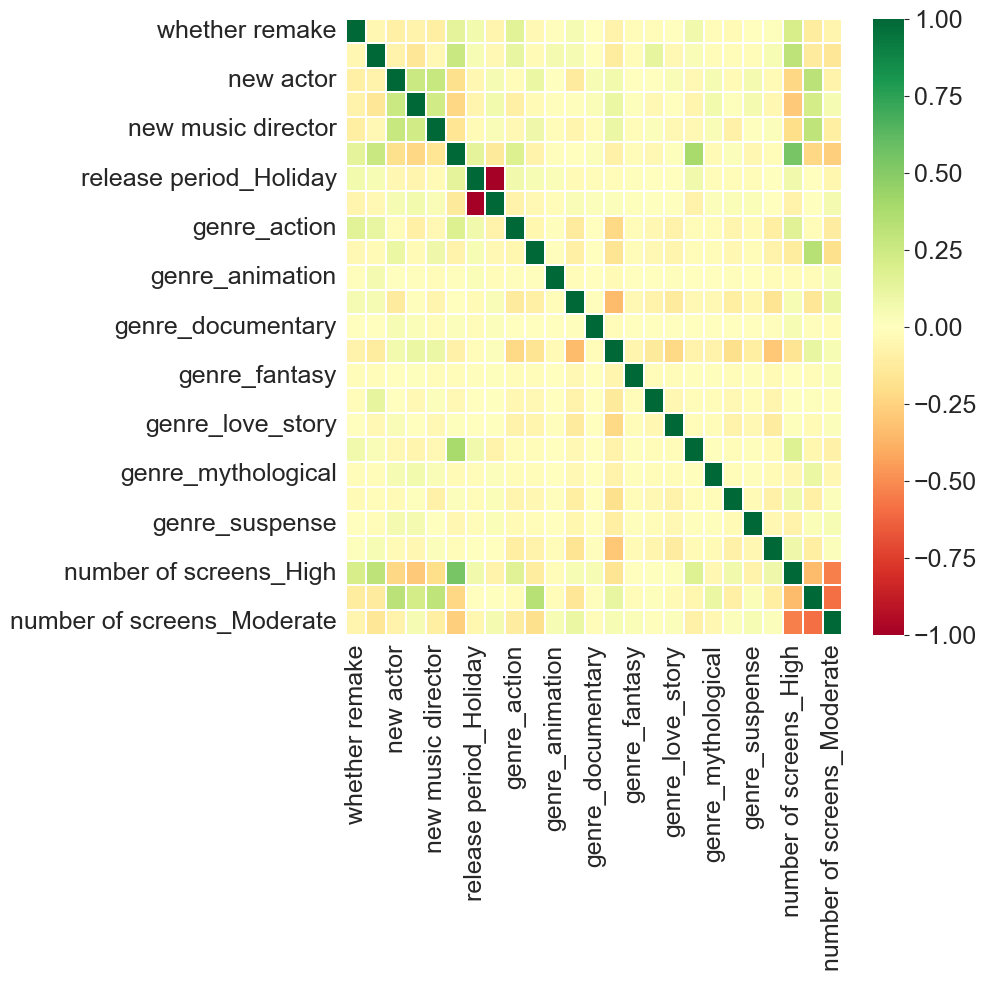

In [84]:
# correlation among the numerical variable
sns.heatmap(d_copy.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = False);

## Models

In [85]:
X1_train,X1_test,Y1_train,Y1_test=train_test_split(d_copy,target,test_size=0.2,random_state=45)

## Random Forest

In [86]:
model1=RandomForestClassifier()
start_time=time.time()
model1.fit(X1_train,Y1_train)
end_time=time.time()
total_time=end_time-start_time
print(f"Model Accuracy is {model1.score(X1_test,Y1_test)}")
print(f"Total time taken for the model to fit is {total_time}")

Model Accuracy is 0.9264705882352942
Total time taken for the model to fit is 0.17950725555419922


Train score 1.0
Test score 0.9264705882352942


Train Confusion matrix


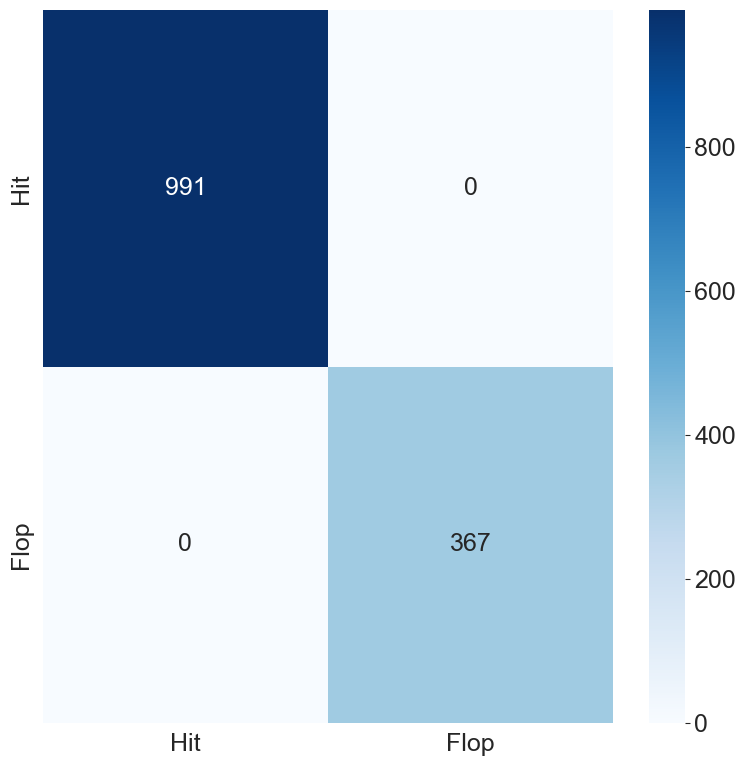

Test Confusion matrix


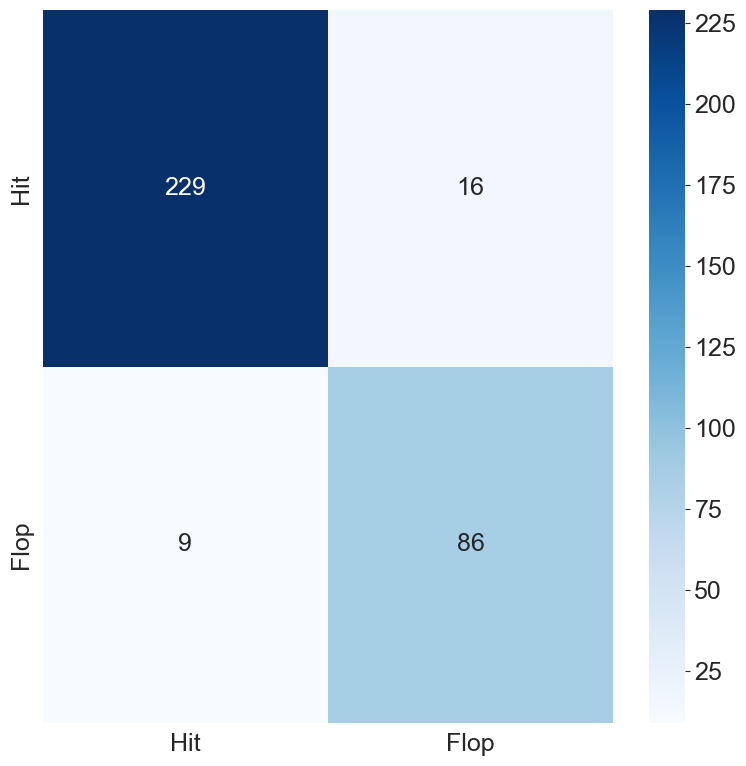

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       238
           1       0.91      0.84      0.87       102

    accuracy                           0.93       340
   macro avg       0.92      0.90      0.91       340
weighted avg       0.93      0.93      0.93       340



In [87]:
Y1_train_pred= model1.predict(X1_train)
Y1_test_pred = model1.predict(X1_test)

classes = ["Hit", "Flop"]

def plot_confusionmatrix(Y1_train_pred,Y1_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(Y1_train_pred,Y1_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
print("\n")
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test')
print(metrics.classification_report(Y1_test, Y1_test_pred))

#### Grid search cross validation


Train score 0.9418262150220913
Test score 0.9323529411764706
Train Confusion matrix


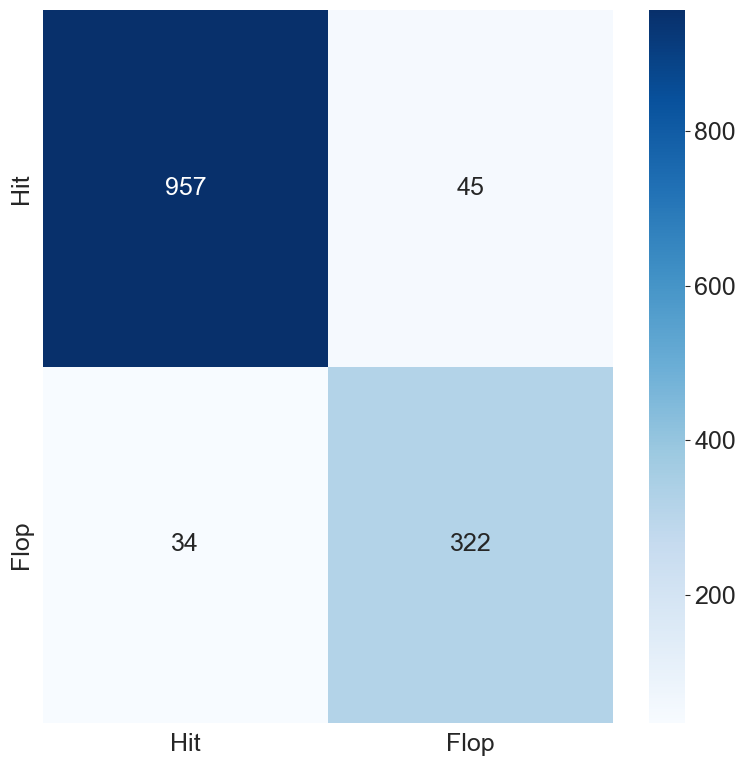

Test Confusion matrix


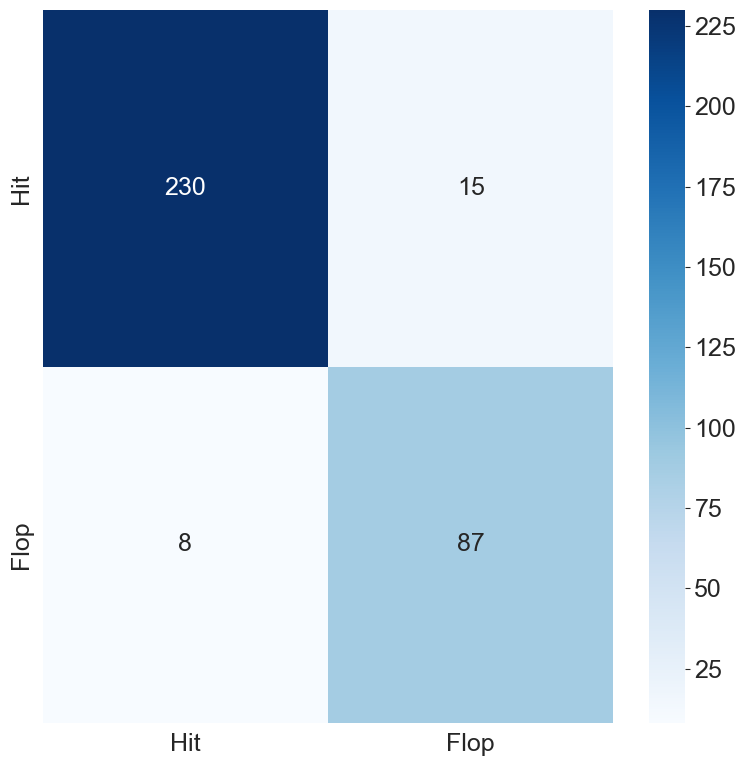

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       238
           1       0.92      0.85      0.88       102

    accuracy                           0.93       340
   macro avg       0.93      0.91      0.92       340
weighted avg       0.93      0.93      0.93       340

Total time taken for the GridSearchCv is 44.47373032569885


In [88]:
params = {'max_depth': [2,3,4,5,6,7,8,9,10,11,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = RandomForestClassifier()
gcv = model_selection.GridSearchCV(estimator=clf,param_grid=params)
start_time=time.time()
gcv.fit(X1_train,Y1_train)
end_time=time.time()
total_time=end_time - start_time

cv_model = gcv.best_estimator_
cv_model.fit(X1_train,Y1_train)
Y1_train_pred = cv_model.predict(X1_train)
Y1_test_pred = cv_model.predict(X1_test)

print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test')
print(metrics.classification_report(Y1_test, Y1_test_pred))
print(f"Total time taken for the GridSearchCv is {total_time}")

In [89]:
cv_model = gcv.best_estimator_
%reload_ext memory_profiler
%memit cv_model.fit(X1_train,Y1_train)

peak memory: 293.78 MiB, increment: 5.38 MiB


## Boosting by Decision Stumps / AdaBoosting

In [90]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 45, max_depth = 1,),random_state = 45,n_estimators = 100, learning_rate = 0.8)
start_time=time.time()
clf.fit(X1_train,Y1_train)
end_time=time.time()
total_time=end_time - start_time
print(total_time)

0.19482874870300293


In [91]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 45, max_depth = 1,),random_state = 45,n_estimators = 100, learning_rate = 0.8)

%reload_ext memory_profiler
%memit clf.fit(X1_train,Y1_train)

peak memory: 291.78 MiB, increment: 1.00 MiB


Train score 0.9226804123711341
Test score 0.9323529411764706
Train Confusion matrix


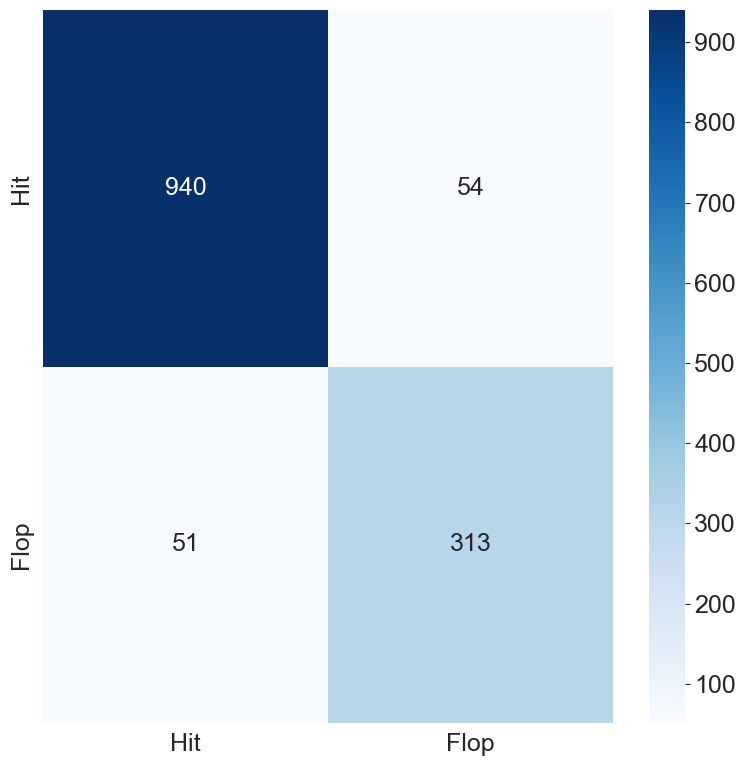

Test Confusion matrix


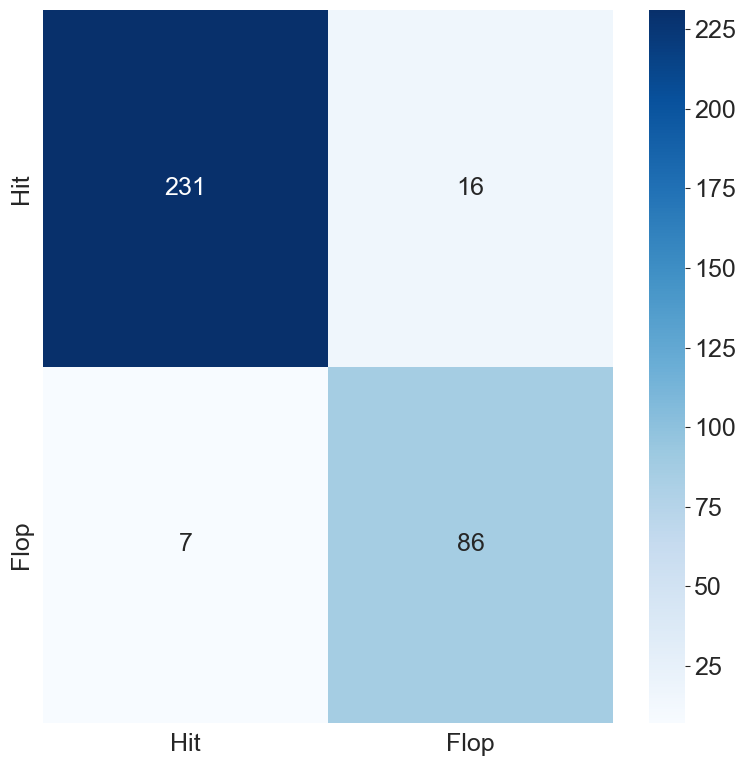

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       238
           1       0.92      0.84      0.88       102

    accuracy                           0.93       340
   macro avg       0.93      0.91      0.92       340
weighted avg       0.93      0.93      0.93       340

Total time taken for AdaBoosting is 0.19482874870300293


In [92]:
Y1_train_pred = clf.predict(X1_train)
Y1_test_pred = clf.predict(X1_test)

classes = ["Hit", "Flop"]

def plot_confusionmatrix(Y1_train_pred,Y1_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(Y1_train_pred,Y1_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()




print(f'Train score {accuracy_score(Y1_train_pred,Y1_train)}')
print(f'Test score {accuracy_score(Y1_test_pred,Y1_test)}')
plot_confusionmatrix(Y1_train_pred,Y1_train,dom='Train')
plot_confusionmatrix(Y1_test_pred,Y1_test,dom='Test')
print(metrics.classification_report(Y1_test, Y1_test_pred))
print(f"Total time taken for AdaBoosting is {total_time}")